In [257]:
import os

In [259]:
# NEed keskkonnamuutujad näitavad kus asuvad pysynphot fajlid ja andmetabelid
os.environ['PYSYN_CDBS'] = "C:\\Users\\kasutaja\\Downloads\\synphot\\trds\\"
os.environ['MOODETUD'] = "C:\\Users\\kasutaja\\Documents\\upt\\andmetabelid\\"

In [260]:
import numpy as np
from astropy.io import fits
import pysynphot as S
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

In [263]:
#Kas näidata testimiseks rohkem infot
DEBUG = False

In [264]:
# Standardfiltrite nimede vastavus nende andmefailidega
filtritabel = {
    'Johnson_B': 'johnson_b_002.fits',
    'Johnson_V': 'johnson_v_002.fits',
    'Johnson_Rc': 'cousins_r_002.fits',
    'Johnson_Ic': 'cousins_i_002.fits',
    'sloan_u': 'sdss_u_005_syn.fits',
    'sloan_g': 'sdss_g_005_syn.fits',
    'sloan_r': 'sdss_r_005_syn.fits',
    'sloan_i': 'sdss_i_005_syn.fits',
    'sloan_zs': 'sdss_z_005_syn.fits'
    }

In [267]:
def moodetud_filter(filtri_nimi:str):
    """Tagastab filtri nime põhjal mõõdetud filtri läbilaskeriba.

    Parameters
    ---------
        filtri_nimi : str
            Filtri nimi (nt. Johnson_B)
    Returns:
        bp: pysynphot bandpass object        
    """
    faili_nimi = "filter_" + filtri_nimi + '.dat'
    filename = os.path.join(os.environ['MOODETUD'], faili_nimi)
    
    bp = S.FileBandpass(filename)
    
    return bp

In [269]:
def standard_filter(filtri_nimi:str):
    """Tagastab filtri nime põhjal standardfiltri läbilaskeriba pysynphot andmebaasist.

    Parameters
    ---------
        filtri_nimi : str
            Filtri nimi (nt. Johnson_B)
    Returns:
        bp: pysynphot bandpass object        
    """
    filename = os.path.join(os.environ['PYSYN_CDBS'], 'comp', 'nonhst', filtritabel[filtri_nimi])
    
    bp = S.FileBandpass(filename)
    
    return bp

In [271]:
# Teeme tühja dicti
filtrinimi = {}
# Mõõdame järgnevate temperatuuridega mudelspektreid
temperatuurid = [4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 9000, 10000, 11000, 12000, 14000, 16000]
    
#kombineeritud läbilaskeriba
teleskoop = S.FileBandpass(os.environ['MOODETUD'] + 'teleskoobi_efektiivsus.dat')
CCD = S.FileBandpass(os.environ['MOODETUD'] + 'ccd_efektiivsus.dat')
CCD_aken = S.FileBandpass(os.environ['MOODETUD'] + 'ccd_akna_efektiivsus.dat')
bp_teleskoop_kaamera = teleskoop * CCD * CCD_aken

for filtri_nimi in filtritabel.keys():
    
    # avab standardfiltri läbilaskeriba
    filename = os.path.join(os.environ['PYSYN_CDBS'], 'comp', 'nonhst', filtritabel[filtri_nimi])
    print(f"filtrifail on: {filename}")
    bp_std = S.FileBandpass(filename)
    # filtri läbilaskekõvera tekitamine
    bp_filter = moodetud_filter(filtri_nimi)
    for temperatuur in temperatuurid:
        #loob mudelspektri etteantud temperatuuri juures
        mudelinimi = 'kp01_' + str(temperatuur) + '.fits'   # Konstrueerime mudelspektri faili nime vastavalt temperatuurile
        nimi = 'kp01_' + str(temperatuur)                   # Konstrueerime mudelspektri nime
        filename = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'k93models', 'kp01', mudelinimi)
        spec = fits.getdata(filename)         # Loeme sisse mudelspektri
        wave = spec['WAVELENGTH']             # Võtame mudelspektrite maatriksist lainepikkuse
        flux = spec['g40']                    # Võtame mudelspektrite tabelist logg=4.0 vastava mudeli energiavoo
        spekter = S.ArraySpectrum(wave, flux, name=nimi)  # Loome PySynphot spektri objekti
        sp_norm = spekter.renorm(10, 'vegamag', bp_std)   # Muudame mudeltähe heleduseks 10 tähesuurust Vega süsteemis
        
        # defineerib vaatluse, mis on määratud temperatuuriga spektriga ja filtriga ning teleskoobi efektiivsuste kogumõjuga
        obs = S.Observation(sp_norm, bp_filter * bp_teleskoop_kaamera)
        heledus = obs.effstim('obmag')
        if DEBUG:
            print(f"Heledus filtris {filtri_nimi} vastavalt temperatuurile {temperatuur} K on:  {heledus}")
        

filtrifail on: C:\Users\kasutaja\Downloads\synphot\trds\comp\nonhst\johnson_b_002.fits
((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efekt

# Mõõdetud filtrite tabeli andmed

In [273]:
# Teeme tühja dicti andmete hoidmiseks
tabeli_andmed = {temp: {} for temp in temperatuurid}

# Loe standardfilter Johnson V
filtri_nimi = 'Johnson_V'
bp_std_V = standard_filter(filtri_nimi)

for filtri_nimi in filtritabel.keys():
    # mõõdetud filtri läbilaskekõvera tekitamine
    bp_filter = moodetud_filter(filtri_nimi)

    for temperatuur in temperatuurid:
        mudelinimi = 'kp01_' + str(temperatuur) + '.fits'
        nimi = 'kp01_' + str(temperatuur)
        filename = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'k93models', 'kp01', mudelinimi) # Kasutame Kuruzci 1993. aasta mudeleid
        
        spec = fits.getdata(filename)
        wave = spec['WAVELENGTH']
        flux = spec['g40']              # Kasutame vastava temperatuuriga mudelite tabelist logg=4.0 vastavat spektrit
        spekter = S.ArraySpectrum(wave, flux, name=nimi)
        sp_norm = spekter.renorm(10, 'vegamag', bp_std_V)  # Normeerime spektri nii, et selle energiavoog vastaks 10. tähesuurusele
        
        obs = S.Observation(sp_norm, bp_filter * bp_teleskoop_kaamera) # Kombineerime vaatluse spektrist, filtri läbilaskekõverast ja teleskoobi ning kaamera efektiivsustest
        heledus = obs.effstim('obmag')
        if DEBUG:
            print(f"Heledus meie filtris {filtri_nimi} vastavalt temperatuurile {temperatuur} K on:  {heledus}")
        
        # Salvesta väärtus tabelisse
        tabeli_andmed[temperatuur][filtri_nimi] = heledus

if DEBUG:
    print(tabeli_andmed)
    
# Teeme pandas DataFrame'i
tabel = pd.DataFrame.from_dict(tabeli_andmed, orient='index')
tabel.index.name = 'temperatuur'
# Näitan tabelit
print(tabel)

((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Documents\upt\andmetabelid\filter_Johnson_B.dat * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Use

# Standardsete filtrite andmete tabel

In [275]:
# Teeb tühja dicti andmete hoimiseks
stdtabeli_andmed = {temp: {} for temp in temperatuurid}

# Loe standardfiltri Johnson V
filtri_nimi = 'Johnson_V'
filename = os.path.join(os.environ['PYSYN_CDBS'], 'comp', 'nonhst', filtritabel[filtri_nimi])
bp_std_V = S.FileBandpass(filename)

for filtri_nimi in filtritabel.keys():
    
    bp_filter = standard_filter(filtri_nimi)

    for temperatuur in temperatuurid:
        mudelinimi = 'kp01_' + str(temperatuur) + '.fits'
        nimi = 'kp01_' + str(temperatuur)
        filename = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'k93models', 'kp01', mudelinimi)
        
        spec = fits.getdata(filename)
        wave = spec['WAVELENGTH']
        flux = spec['g40']
        spekter = S.ArraySpectrum(wave, flux, name=nimi)
        sp_norm = spekter.renorm(10, 'vegamag', bp_std_V)

        obs = S.Observation(sp_norm, bp_filter * bp_teleskoop_kaamera)
        #obs = S.Observation(sp_norm, bp_filter)
        heledus = obs.effstim('obmag')
        if DEBUG:
            print(f"Heledus standardfiltris {filtri_nimi} vastavalt temperatuurile {temperatuur} K on:  {heledus}")
        
        # Salvesta väärtus tabelisse
        stdtabeli_andmed[temperatuur][filtri_nimi] = heledus

if DEBUG:
    print(stdtabeli_andmed)

# Teeme pandas DataFrame'i
stdtabel = pd.DataFrame.from_dict(stdtabeli_andmed, orient='index')
stdtabel.index.name = 'temperatuur'

# Näitab tabelit
print(stdtabel)

((C:\Users\kasutaja\Downloads\synphot\trds\comp\nonhst\johnson_b_002.fits * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Downloads\synphot\trds\comp\nonhst\johnson_b_002.fits * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektiivsus.dat) * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_akna_efektiivsus.dat))) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((C:\Users\kasutaja\Downloads\synphot\trds\comp\nonhst\johnson_b_002.fits * ((C:\Users\kasutaja\Documents\upt\andmetabelid\teleskoobi_efektiivsus.dat * C:\Users\kasutaja\Documents\upt\andmetabelid\ccd_efektii

# Regressioonid värviülekande kordajate leidmiseks

## Värviülekande regressioonid

### B vs (B-V)

Värviülekande kordaja= -0.0451
Standardhälve= 0.0014


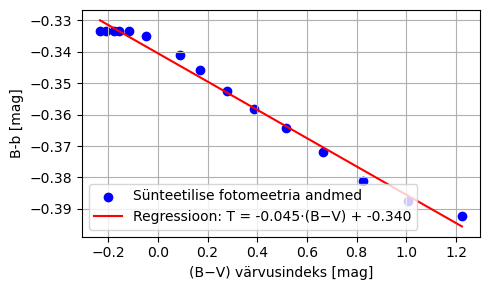

In [277]:
# Arvuta B–V värvusindeks
tabel['B-V'] = tabel['Johnson_B'] - tabel['Johnson_V']

# Arvuta Standard ja tavalise B filtri vahe
tabel['B-b'] = stdtabel['Johnson_B'] - tabel['Johnson_B']

# Värvusindeks (x) ja B-b (y)
x = tabel['B-V'].values
y = tabel['B-b'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)

#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusindeksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(B−V) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(B−V) värvusindeks [mag]')
plt.ylabel('B-b [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_B_vs_BV.pdf")
plt.show()

### V vs (B-V)

Värviülekande kordaja= 0.0286
Standardhälve= 0.0008


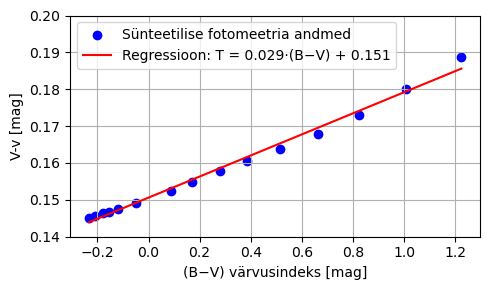

In [280]:
# Arvuta B–V värvusindeks
tabel['B-V'] = tabel['Johnson_B'] - tabel['Johnson_V']
# Arvuta Standard ja tavalise V filtri vahe
tabel['V-v'] = stdtabel['Johnson_V'] - tabel['Johnson_V']
# Värvusindeks (x) ja V-v (y)
x = tabel['B-V'].values
y = tabel['V-v'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
#plt.scatter(x, y, color='blue', label='S')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(B−V) + {intercept:.3f}')
#plt.plot(x_fit, y_fit, color='red', label='R')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(B−V) värvusindeks [mag]')
plt.ylabel('V-v [mag]')
plt.ylim(0.14,0.20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_V_vs_BV.pdf")
plt.show()

### Rc vs (V-Rc)

Värviülekande kordaja= -0.0270
Standardhälve= 0.0006


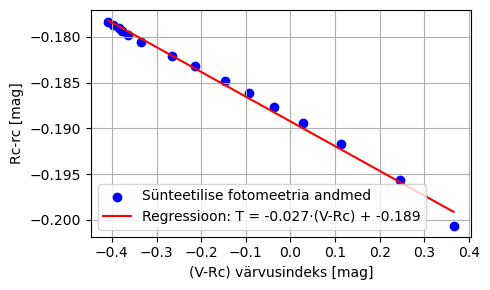

In [283]:
# Arvuta V-Rc värvusindeks
tabel['V-Rc'] = tabel['Johnson_V'] - tabel['Johnson_Rc']
# Arvuta Standard ja tavalise V filtri vahe
tabel['Rc-rc'] = stdtabel['Johnson_Rc'] - tabel['Johnson_Rc']
# Värvusindeks (x) ja R-Ic (y)
x = tabel['V-Rc'].values
y = tabel['Rc-rc'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Plot
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Rc) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(V-Rc) värvusindeks [mag]')
plt.ylabel('Rc-rc [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_Rc_vs_VRc.pdf")
plt.show()

### Rc vs (Rc-Ic)

Värviülekande kordaja= -0.0232
Standardhälve= 0.0005


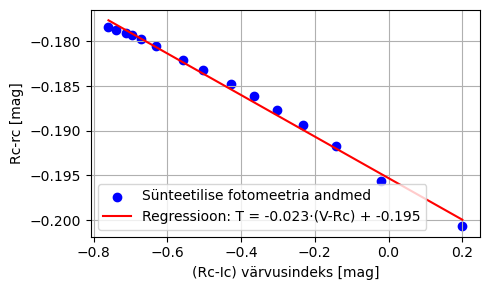

In [286]:
# Arvuta Rc-Ic värvusindeks
tabel['Rc-Ic'] = tabel['Johnson_Rc'] - tabel['Johnson_Ic']
# Arvuta Standard ja tavalise V filtri vahe
tabel['Rc-rc'] = stdtabel['Johnson_Rc'] - tabel['Johnson_Rc']
# Värvusindeks (x) ja Rc-rc (y)
x = tabel['Rc-Ic'].values
y = tabel['Rc-rc'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err  = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Rc) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(Rc-Ic) värvusindeks [mag]')
plt.ylabel('Rc-rc [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_Rc_vs_RcIc.pdf")
plt.show()

### V vs (V-Rc)

Värviülekande kordaja= 0.0545
Standardhälve= 0.0009


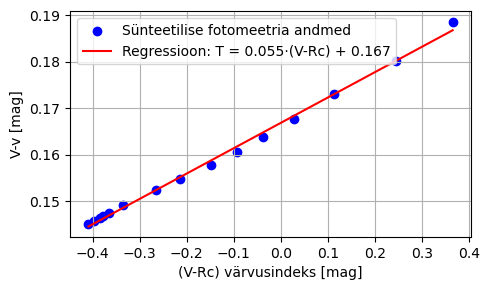

In [289]:
# Arvuta V-Rc värvusindeks
tabel['V-Rc'] = tabel['Johnson_V'] - tabel['Johnson_Rc']
# Arvuta Standard ja tavalise V filtri vahe
tabel['V-v'] = stdtabel['Johnson_V'] - tabel['Johnson_V']
# Värvusindeks (x) ja V-v (y)
x = tabel['V-Rc'].values
y = tabel['V-v'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Rc) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(V-Rc) värvusindeks [mag]')
plt.ylabel('V-v [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_V_vs_VRc.pdf")
plt.show()

### V vs (V-Ic)

Värviülekande kordaja= 0.0252
Standardhälve= 0.0004


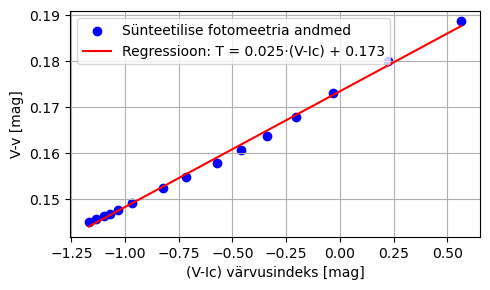

In [292]:
# Arvuta V-Ic värvusindeks
tabel['V-Ic'] = tabel['Johnson_V'] - tabel['Johnson_Ic']
# Arvuta Standard ja tavalise V filtri vahe
tabel['V-v'] = stdtabel['Johnson_V'] - tabel['Johnson_V']
# Värvusindeks (x) ja V-v (y)
x = tabel['V-Ic'].values
y = tabel['V-v'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku

#plt.figure(figsize=(8, 5))
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Ic) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(V-Ic) värvusindeks [mag]')
plt.ylabel('V-v [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_V_vs_VIc.pdf")
plt.show()

### Ic vs (Rc-Ic)

Värviülekande kordaja= 0.1406
Standardhälve= 0.0079


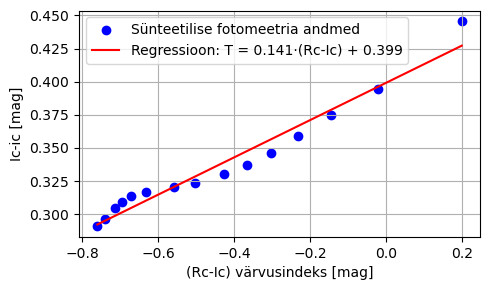

In [295]:
# Arvuta Rc-Ic värvusindeks
tabel['Rc-Ic'] = tabel['Johnson_Rc'] - tabel['Johnson_Ic']
# Arvuta Standard ja tavalise V filtri vahe
tabel['Ic-ic'] = stdtabel['Johnson_Ic'] - tabel['Johnson_Ic']
# Värvusindeks (x) ja Ic-ic (y)
x = tabel['Rc-Ic'].values
y = tabel['Ic-ic'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(Rc-Ic) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(Rc-Ic) värvusindeks [mag]')
plt.ylabel('Ic-ic [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_Ic_vs_RcIc.pdf")
plt.show()

### Ic vs (V-Ic)

Värviülekande kordaja= 0.0755
Standardhälve= 0.0046


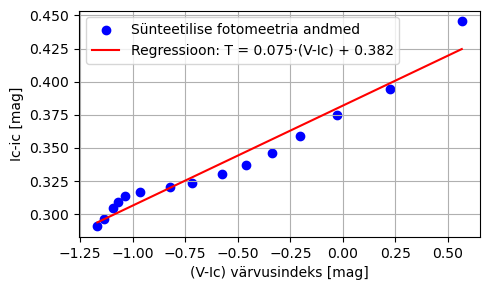

In [297]:
# Arvuta V-Ic värvusindeks
tabel['V-Ic'] = tabel['Johnson_V'] - tabel['Johnson_Ic']
# Arvuta Standard ja tavalise V filtri vahe
tabel['Ic-ic'] = stdtabel['Johnson_Ic'] - tabel['Johnson_Ic']
# Värvusindeks (x) ja Ic-ic (y)
x = tabel['V-Ic'].values
y = tabel['Ic-ic'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
    
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Ic) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(V-Ic) värvusindeks [mag]')
plt.ylabel('Ic-ic [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_Ic_vs_VIc.pdf")
plt.show()

### u vs (u-g)

Värviülekande kordaja= -0.0131
Standardhälve= 0.0258


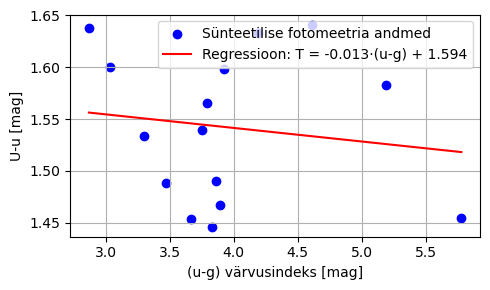

In [300]:
# u-filter
# Arvuta u-g värvusindeks
tabel['u-g'] = tabel['sloan_u'] - tabel['sloan_g']
# Arvuta Standard ja mõõdetud u' filtri vahe
tabel['U-u'] = stdtabel['sloan_u'] - tabel['sloan_u']
# Värvusindeks (x) ja U'-u' (y)
x = tabel['u-g'].values
y = tabel['U-u'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(u-g) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(u-g) värvusindeks [mag]')
plt.ylabel('U-u [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_u_vs_ug.pdf")
plt.show()

### g vs (g-r)

Värviülekande kordaja= 0.0395
Standardhälve= 0.0050


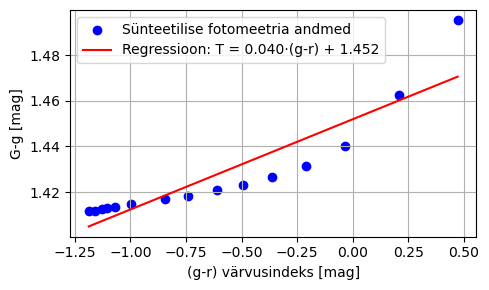

In [303]:
# g-filter
# Arvuta g-r värvusindeks
tabel['g-r'] = tabel['sloan_g'] - tabel['sloan_r']
# Arvuta Standard ja tavalise V filtri vahe
tabel['G-g'] = stdtabel['sloan_g'] - tabel['sloan_g']
# Värvusindeks (x) ja G'-g' (y)
x = tabel['g-r'].values
y = tabel['G-g'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(g-r) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(g-r) värvusindeks [mag]')
plt.ylabel('G-g [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_g_vs_gr.pdf")
plt.show()

### r vs (r-i)

Värviülekande kordaja= 0.0847
Standardhälve= 0.0043


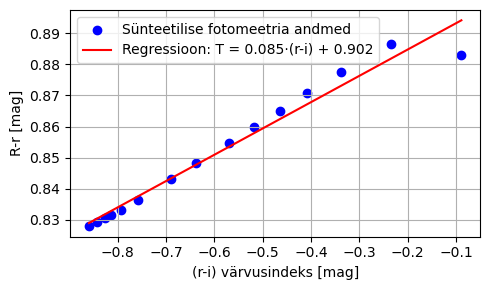

In [306]:
# r-filter
# Arvuta r-i värvusindeks
tabel['r-i'] = tabel['sloan_r'] - tabel['sloan_i']
# Arvuta Standard ja tavalise V filtri vahe
tabel['R-r'] = stdtabel['sloan_r'] - tabel['sloan_r']
# Värvusindeks (x) ja R-r (y)
x = tabel['r-i'].values
y = tabel['R-r'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(r-i) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(r-i) värvusindeks [mag]')
plt.ylabel('R-r [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_r_vs_ri.pdf")
plt.show()

### i vs (i-zs)

Värviülekande kordaja= 0.2512
Standardhälve= 0.0053


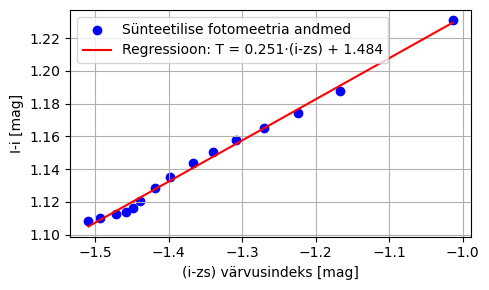

In [309]:
# i-filte
# Arvuta i'-zs'värvusindeks
tabel['i-zs'] = tabel['sloan_i'] - tabel['sloan_zs']

# Arvuta Standard ja tavalise i' filtri vahe
tabel['I-i'] = stdtabel['sloan_i'] - tabel['sloan_i']

# Värvusindeks (x) ja I'-i' (y)
x = tabel['i-zs'].values
y = tabel['I-i'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(i-zs) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(i-zs) värvusindeks [mag]')
plt.ylabel('I-i [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_i_vs_izs.pdf")
plt.show()

### zs vs (i-zs)

Värviülekande kordaja= -0.0101
Standardhälve= 0.0019


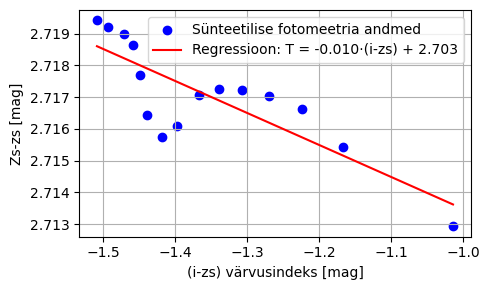

In [313]:
# zs filter
# Arvuta i-zs värvusindeks
tabel['i-zs'] = tabel['sloan_i'] - tabel['sloan_zs']
# Arvuta Standard ja tavalise V filtri vahe
tabel['Zs-zs'] = stdtabel['sloan_zs'] - tabel['sloan_zs']
# Värvusindeks (x) ja Zs-zs (y)
x = tabel['i-zs'].values
y = tabel['Zs-zs'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
#y-teljel peab olema Standardfiltri heledus - mõõdetud filtri heledus, x-teljel peab olema värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(i-zs) + {intercept:.3f}')
print(f'Värviülekande kordaja= {slope:.4f}')
print(f'Standardhälve= {std_err:.4f}')
plt.xlabel('(i-zs) värvusindeks [mag]')
plt.ylabel('Zs-zs [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varviulekanne_zs_vs_i-zs.pdf")
plt.show()

## Värvusindeksite regressioonid

### (b-v) vs (B-V)

Värvusindeksi ülekande kordaja= 1.0795
Vabaliige= 0.5301
Standard hälve= 0.0018


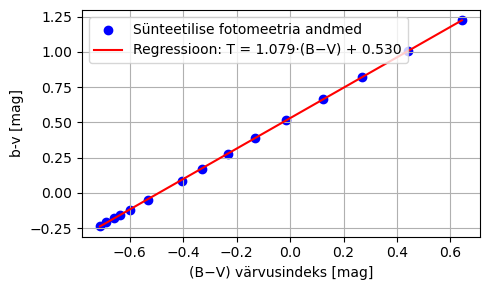

In [317]:
# Arvuta B–V standardne värvusindeks
tabel['B-V'] = stdtabel['Johnson_B'] - stdtabel['Johnson_V']
# Arvuta b-v instrumentaalne värvusindeks 
tabel['b-v'] = tabel['Johnson_B'] - tabel['Johnson_V']
# Värvusindeks (x) ja b-v (y)
x = tabel['B-V'].values
y = tabel['b-v'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(B−V) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(B−V) värvusindeks [mag]')
plt.ylabel('b-v [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_B_vs_BV.pdf")
plt.show()

### (v- rc) vs (V-Rc)

Värvusindeksi ülekande kordaja= 0.9246
Vabaliige= -0.3292
Standard hälve= 0.0013


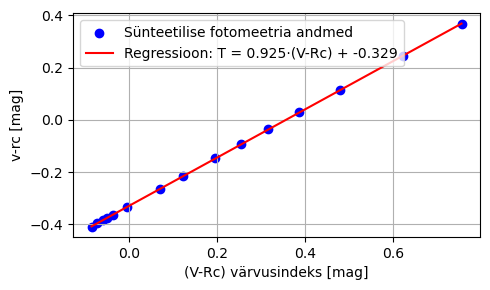

In [320]:
# Arvuta V-Rc värvusindeks
tabel['V-Rc'] = stdtabel['Johnson_V'] - stdtabel['Johnson_Rc']
# Arvuta v-rc instrumentaalne värvusindeks
tabel['v-rc'] = tabel['Johnson_V'] - tabel['Johnson_Rc']
# Värvusindeks (x) ja v-rc (y)
x = tabel['V-Rc'].values
y = tabel['v-rc'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Rc) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(V-Rc) värvusindeks [mag]')
plt.ylabel('v-rc [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_Rc_vs_VRc.pdf")
plt.show()

### (rc-ic) vs (Rc-Ic)

Värvusindeksi ülekande kordaja= 1.1944
Vabaliige= 0.7093
Standard hälve= 0.0118


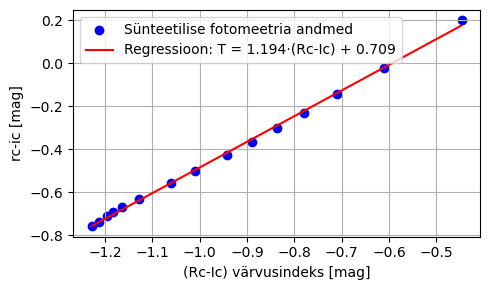

In [323]:
# Arvuta Rc-Ic värvusindeks
tabel['Rc-Ic'] = stdtabel['Johnson_Rc'] - stdtabel['Johnson_Ic']
# Arvuta rc-ic instrumentaalne värvusindeks
tabel['rc-ic'] = tabel['Johnson_Rc'] - tabel['Johnson_Ic']
# Värvusindeks (x) ja rc-ic (y)
x = tabel['Rc-Ic'].values
y = tabel['rc-ic'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(Rc-Ic) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(Rc-Ic) värvusindeks [mag]')
plt.ylabel('rc-ic [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_Ic_vs_RcIc.pdf")
plt.show()

### (v-ic) vs (V-Ic)

Värvusindeksi ülekande kordaja= 1.0526
Vabaliige= 0.2193
Standard hälve= 0.0048


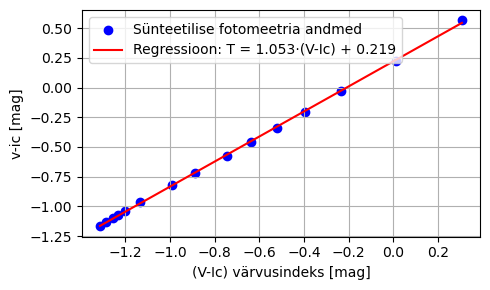

In [326]:
# Arvuta V-Ic värvusindeks
tabel['V-Ic'] = stdtabel['Johnson_V'] - stdtabel['Johnson_Ic']
# Arvuta v-ic instrumentaalne värvusindeks
tabel['v-ic'] = tabel['Johnson_V'] - tabel['Johnson_Ic']
# Värvusindeks (x) ja v-ic (y)
x = tabel['V-Ic'].values
y = tabel['v-ic'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(V-Ic) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(V-Ic) värvusindeks [mag]')
plt.ylabel('v-ic [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_Ic_vs_VIc.pdf")
plt.show()

### (u-g) vs (U-G)

Värvusindeksi ülekande kordaja= 1.0342
Vabaliige= -0.2535
Standard hälve= 0.0271


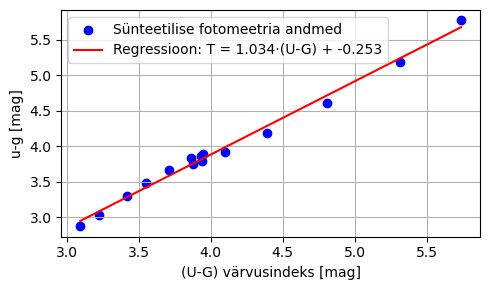

In [329]:
# Arvuta U-G värvusindeks
tabel['U-G'] = stdtabel['sloan_u'] - stdtabel['sloan_g']
# Arvuta u-g instrumentaalne värvusindeks
tabel['u-g'] = tabel['sloan_u'] - tabel['sloan_g']
# Värvusindeks (x) ja u-g (y)
x = tabel['U-G'].values
y = tabel['u-g'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(U-G) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(U-G) värvusindeks [mag]')
plt.ylabel('u-g [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_u_vs_ug.pdf")
plt.show()

### (g-r) vs (G-R)

Värvusindeksi ülekande kordaja= 0.9983
Vabaliige= -0.5758
Standard hälve= 0.0068


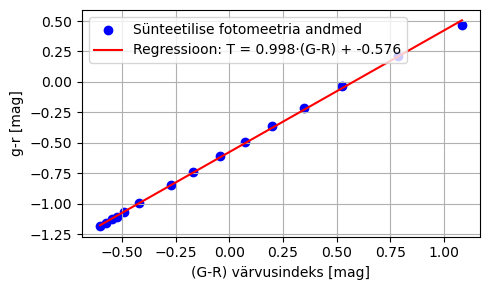

In [332]:
# Arvuta G-R värvusindeks
tabel['G-R'] = stdtabel['sloan_g'] - stdtabel['sloan_r']
# Arvuta g-r instrumentaalne värvusindeks
tabel['g-r'] = tabel['sloan_g'] - tabel['sloan_r']
# Värvusindeks (x) ja g-r (y)
x = tabel['G-R'].values
y = tabel['g-r'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(G-R) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(G-R) värvusindeks [mag]')
plt.ylabel('g-r [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_g_vs_gr.pdf")
plt.show()

### (r-i) vs (R-I)

Värvusindeksi ülekande kordaja= 1.0593
Vabaliige= 0.3443
Standard hälve= 0.0118


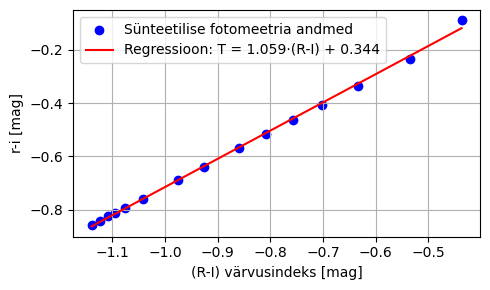

In [335]:
# Arvuta R-I värvusindeks
tabel['R-I'] = stdtabel['sloan_r'] - stdtabel['sloan_i']
# Arvuta r-i instrumentaalne värvusindeks
tabel['r-i'] = tabel['sloan_r'] - tabel['sloan_i']
# Värvusindeks (x) ja r-i (y)
x = tabel['R-I'].values
y = tabel['r-i'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(R-I) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(R-I) värvusindeks [mag]')
plt.ylabel('r-i [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_r_vs_ri.pdf")
plt.show()

### (i-zs) vs (I-Zs)

Värvusindeksi ülekande kordaja= 0.7926
Vabaliige= 0.9660
Standard hälve= 0.0036


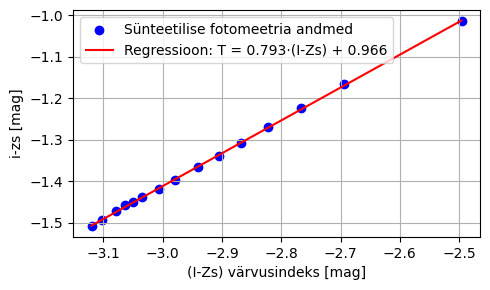

In [338]:
# Arvuta I-Zs värvusindeks
tabel['I-Zs'] = stdtabel['sloan_i'] - stdtabel['sloan_zs']
# Arvuta i-zs instrumentaalne värvusindeks
tabel['i-zs'] = tabel['sloan_i'] - tabel['sloan_zs']
# Värvusindeks (x) ja i-zs (y)
x = tabel['I-Zs'].values
y = tabel['i-zs'].values 
if DEBUG:
    # Väljastab standardsed värvusindeksid ja standard- ja instrumentaalsete heleduste vahe
    print(x)
    print(y)
# y-teljel peab olema instrumentaalne värvusindeks, x-teljel standardne värvusindeks
# Teeme lineaarse regressiooni
slope, intercept, r, p, std_err = linregress(x, y)

# Genereeritud värvusineksid regressioonimudeli järgi
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Teeme graafiku
plt.figure(figsize=(5, 3))
plt.scatter(x, y, color='blue', label='Sünteetilise fotomeetria andmed')
plt.plot(x_fit, y_fit, color='red', label=f'Regressioon: T = {slope:.3f}·(I-Zs) + {intercept:.3f}')
print(f'Värvusindeksi ülekande kordaja= {slope:.4f}')
print(f'Vabaliige= {intercept:.4f}')
print(f'Standard hälve= {std_err:.4f}')
plt.xlabel('(I-Zs) värvusindeks [mag]')
plt.ylabel('i-zs [mag]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("varvusindeks_i_vs_izs.pdf")
plt.show()